# **Importing Libraries**

In [ ]:
!pip install opendatasets

In [ ]:
# Data Handling
import opendatasets as od
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Machine Learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize

# Evaluation Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, log_loss, roc_curve, auc

# Others
import random
from datetime import datetime
from itertools import cycle
from google.colab import files


# **Downloading the dataset**

If you want to run,
provide your Kaggle credentials below

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification")

Skipping, found downloaded files in "./garbage-classification" (use force=True to force download)


# **Displaying the dataset**

This code defines a function, `display_random_images`, which is designed to visually explore the dataset by displaying a specified number of random images from different classes. It operates on a dataset organized in a directory structure where each class has its own subdirectory. Here's a detailed explanation of the function that you can use in a Colab notebook text cell:

---

This function, `display_random_images`, serves to showcase a sample of images from a structured dataset, where images are categorized into classes, each within its own subdirectory. The purpose is to provide a quick visual inspection of the dataset's diversity and class representation. The function's operation can be broken down into several key steps:

1. **Directory Listing**: It starts by creating a list of class directories within the base dataset path. This is achieved by iterating over all items in the base directory, filtering for directories only. This step ensures that each class is represented.

2. **Figure Setup**: Prepares a matplotlib figure with a specified size, designed to accommodate the display of multiple images in a single row.

3. **Random Image Display**: For each image to be displayed (as specified by `num_images`), the function performs the following actions:
   - **Class Selection**: Randomly selects one of the class directories, ensuring that the displayed images may come from any of the available classes, providing a varied sample.
   - **Image Selection**: Within the chosen class directory, it randomly selects an image file. This randomness ensures that each function call provides a potentially unique glimpse into the dataset.
   - **Image Loading and Resizing**: The selected image is loaded and resized to a uniform dimension (300x300 pixels in this case), making the display consistent and visually coherent.
   - **Image Display**: Displays the loaded image in a subplot, with the class name (derived from the directory name) displayed as the title. This aids in identifying which class each image belongs to at a glance.

4. **Plot Finalization**: Finally, it disables the axis for a cleaner look and displays the plot. This visual representation allows for an immediate understanding of the nature of the dataset, including aspects like image quality, class variability, and potential challenges for a machine learning model.

This function is particularly useful in the exploratory data analysis phase of a machine learning project, offering insights into the dataset's composition and helping identify if further preprocessing or augmentation might be necessary.



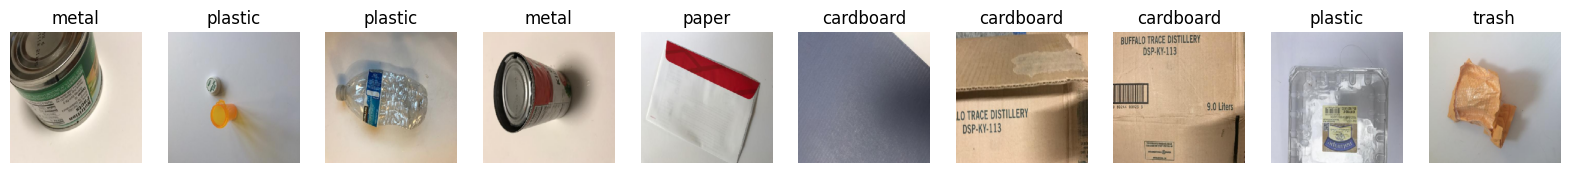

In [ ]:
base_path = '/content/garbage-classification/garbage classification/Garbage classification'
def display_random_images(base_path, num_images=5):
    """
    Display random images from different classes in the dataset.

    Parameters:
    - base_path: The base directory containing the dataset, with each subdirectory named after a class.
    - num_images: The number of random images to display.
    """
    # Get all class directories
    class_dirs = [os.path.join(base_path, d) for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    plt.figure(figsize=(20, 10))

    for i in range(num_images):
        # Randomly select a class directory
        class_dir = random.choice(class_dirs)
        class_name = os.path.basename(class_dir)

        # Get a random image from the class directory
        random_image_file = random.choice(os.listdir(class_dir))
        image_path = os.path.join(class_dir, random_image_file)

        # Load and display the image
        img = load_img(image_path, target_size=(300, 300))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.show()

display_random_images(base_path, num_images=10)


# **Dataset Preprocessing**

This coding part utilizes the `ImageDataGenerator` class to automatically handle image loading, preprocessing, augmentation, and the division of data into training and validation sets.

### ImageDataGenerator Configuration

- **train_datagen**: An instance of `ImageDataGenerator` configured with various image augmentation parameters (like `shear_range`, `zoom_range`, `width_shift_range`, `height_shift_range`, `horizontal_flip`, `vertical_flip`) and normalization (`rescale=1./255` to scale pixel values to the range [0, 1]). Additionally, a `validation_split` is defined to reserve a portion of the data for validation.
  
- **test_datagen**: Another `ImageDataGenerator` instance, but with minimal preprocessing (only `rescale` for normalization and `validation_split` for data splitting), typically used for validation or test data to evaluate the model.

### Data Loading and Augmentation

- **train_generator**: Uses `train_datagen.flow_from_directory` to load images from `base_path` for training. Images are resized to 300x300 pixels to ensure uniformity, batched into groups of 16, and categorized (`class_mode='categorical'`). It targets the 'training' subset of data based on the `validation_split` defined in `train_datagen`.

- **validation_generator**: Similar to `train_generator`, but uses `test_datagen` to load images for validation, ensuring no augmentation (beyond rescaling) is applied to this data.

### Label Mapping

- **labels**: Extracts the mapping of class indices to class names from `train_generator.class_indices` and inverts it (making the class index the key and the class name the value). This is useful for interpreting the model's predictions, converting numeric predictions back to understandable class names.



In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0,
    shuffle=False
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


### **Add test set**

In [ ]:
test_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

Found 251 images belonging to 6 classes.


# **CNN Model with regularizer and Dropout**


### Model Architecture

The model is built using the `Sequential` API from Keras, allowing us to stack layers in a linear fashion. The architecture comprises several key components designed to extract features from images and classify them into one of six categories:

- **Convolutional Layers**: The model starts with a series of three convolutional layers (`Conv2D`), each followed by max pooling (`MaxPooling2D`). Convolutional layers are the core building blocks of a CNN, responsible for capturing patterns in images such as edges, textures, or more complex patterns in deeper layers. Each convolutional layer in this model uses L2 regularization to combat overfitting by penalizing large weights, with a regularization factor of `0.001`.

- **Flattening**: After the convolutional and pooling layers, the `Flatten` layer transforms the 3D output to a 1D vector, making it possible to connect convolutional layers to dense layers.

- **Dense Layer**: A fully connected (`Dense`) layer follows, also with L2 regularization, serving to interpret the features extracted by the convolutional layers and pooling layers. It has 128 units and uses the ReLU activation function.

- **Dropout**: The `Dropout` layer is included with a rate of `0.5`, which helps prevent overfitting by randomly setting input units to 0 at each update during training time, thus reducing the chance for neurons to co-adapt too much.

- **Output Layer**: The final layer is a dense layer with a softmax activation function, designed to output the probability distribution across the six classes. The number of units matches the number of classes (`num_classes`).

### Compilation

The model is compiled with the Adam optimizer, a popular choice for deep learning applications due to its adaptive learning rate properties. The loss function used is `categorical_crossentropy`, suitable for multi-class classification problems. The model's performance is evaluated based on accuracy.

### Training

The model is trained using the `fit` method, with data provided by `train_generator` and `validation_generator`. These generators supply batches of images and labels for training and validation, respectively, applying real-time data augmentation to the training images to improve generalization. The training process is set to run for 10 epochs, with each epoch working through the entire dataset once. `steps_per_epoch` and `validation_steps` are calculated by dividing the total number of samples by the batch size, ensuring that the model sees all training and validation data in each epoch.

### Summary

The `model.summary()` call provides an overview of the model's architecture, including the output shapes and number of parameters at each layer, offering insight into the model's complexity and capacity.



In [ ]:
# Model parameters
input_shape = (300, 300, 3)
num_classes = 6

In [ ]:
model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

In [ ]:
model.save("cnn.h5")
model.save("cnn.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Loss Curve**


### Visualizing the Model's Learning Curve

To gauge the performance of a neural network during its training phase, it's insightful to observe the changes in loss values across epochs. Loss values signify how well the model's predictions match the actual labels, with lower values indicating better performance. This code snippet generates two critical curves:

- **Training Loss Curve**: Represents the model's loss on the training dataset after each epoch. A decreasing trend in this curve signifies that the model is learning from the training data, capturing the underlying patterns to make accurate predictions.

- **Validation Loss Curve**: Shows the model's loss on a separate validation dataset not seen during training. This curve is crucial for evaluating how well the model generalizes to new, unseen data. Ideally, both the training and validation loss should decrease over time and converge to a low value. If the validation loss begins to increase or diverge from the training loss, it may indicate overfitting, suggesting that the model is learning noise from the training data rather than useful patterns.

#### Key Components of the Code:

- **Extract Loss Data**: The `history.history['loss']` and `history.history['val_loss']` extract the recorded training and validation loss values from the model's history object.

- **Epoch Range**: `range(1, len(training_loss) + 1)` generates a sequence of epoch numbers, starting from 1 to the total number of epochs, to use as the x-axis in the plot.

- **Plotting**: The `plt.plot` function is used to draw the loss curves, with different styles for training and validation losses to distinguish them easily.

    - The training loss is plotted in blue with circle markers (`o`), and the validation loss is plotted in red with the same type of markers.
    - Line styles (`linestyle='-'`) and line widths (`linewidth=2`) are specified for clarity.

- **Plot Customization**: Titles and labels for the axes are set using `plt.title`, `plt.xlabel`, and `plt.ylabel`. A legend (`plt.legend()`) distinguishes between the two curves, and a grid (`plt.grid(True)`) is added for better readability of the plot.

- **Displaying the Plot**: Finally, `plt.show()` renders the plot on the screen.

#### Whats the point of using Loss Curves?

- **Model Evaluation**: These curves are a direct window into the model's learning process, revealing trends that numeric metrics alone might not show. They help in assessing if the model is improving and at what rate.

- **Diagnosing Model Issues**: By examining the loss curves, one can identify issues such as overfitting (where the validation loss increases after a point) or underfitting (where both losses remain high or decrease very slowly).

- **Informing Training Decisions**: The insights gained from these curves can guide decisions on whether to continue training, adjust learning rates, or modify the model's architecture.

This visualization is a staple in machine learning diagnostics, offering a straightforward method to monitor and assess model training progress.



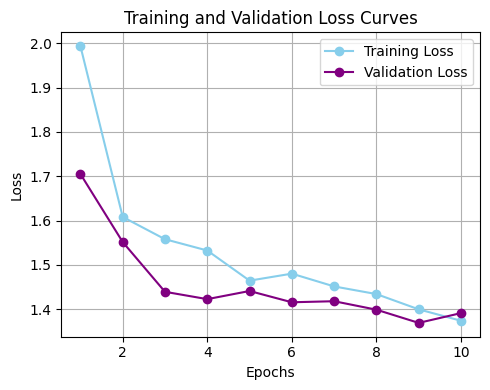

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(epochs, training_loss, label='Training Loss', color='skyblue', marker='o', linestyle='-', linewidth=1.5)
plt.plot(epochs, validation_loss, label='Validation Loss', color='purple', marker='o', linestyle='-', linewidth=1.5)

plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('/content/DenseNet121_losscurves.png', transparent=True)
plt.show()


This plot illustrates the training and validation loss curves for a machine learning model over 10 epochs. The loss is a measure of how well the model is performing; a lower loss indicates a better model.

### Training Loss (Blue Curve)
The blue curve represents the loss on the training dataset. This curve starts significantly higher, which suggests that the model began with a relatively poor understanding of the data. However, as epochs progress, the training loss decreases sharply, indicating that the model is learning and improving its predictions on the training data. After the initial sharp decline, the curve begins to flatten out, showing smaller improvements as the model starts to converge to a solution.

### Validation Loss (Red Curve)
The red curve denotes the loss on the validation dataset. This curve is crucial because it indicates how well the model generalizes to new, unseen data. Initially, the validation loss decreases, similar to the training loss, which is a good sign. However, it then shows some volatility, increasing and decreasing throughout the remaining epochs. Ideally, we would like this curve to decrease and then stabilize, just like the training loss.

### Analysis and Potential Actions
- **Early Convergence**: Both curves converge early on, which suggests that either the model has quickly learned the primary structure in the dataset or it might be too simple and isn't capable of capturing more complex patterns.
  
- **Overfitting**: There is no clear sign of overfitting here, as the validation loss does not increase consistently as the epochs progress. Overfitting would typically be indicated by a continuous increase in the validation loss, diverging from the training loss.

- **Noise in Validation Loss**: The fluctuations in the validation loss could be due to the small size of the validation set or stochastic factors related to the training process (like mini-batch gradient descent).

- **Early Stopping**: If continued training leads to a consistent increase in validation loss, it may be wise to implement an early stopping mechanism to halt training when the model begins to overfit.

By analyzing these curves, we can infer a lot about the training dynamics and make informed decisions to try and improve the model's performance.

## **F1 Score**

In [ ]:
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

# Converting predictions from one-hot encoded to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate the F1 score
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print('F1 Score:', f1)

16/16 [==============================] - 1s 74ms/step
F1 Score: 0.4628760306069936


In [ ]:
# Generate and print a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Note: This returns the loss and accuracy defined during model compilation
loss, accuracy = model.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

              precision    recall  f1-score   support

   cardboard       0.61      0.68      0.64        40
       glass       0.45      0.50      0.47        50
       metal       0.33      0.51      0.40        41
       paper       0.70      0.39      0.50        59
     plastic       0.38      0.42      0.40        48
       trash       0.33      0.08      0.12        13

    accuracy                           0.47       251
   macro avg       0.47      0.43      0.42       251
weighted avg       0.50      0.47      0.46       251

16/16 [==============================] - 1s 69ms/step - loss: 1.4292 - accuracy: 0.4661
Loss: 1.4292
Accuracy: 0.4661



## **Visualizing Confusion Matrix Using Heatmaps**

The confusion matrix is a crucial diagnostic tool in classification tasks as it provides insight into the types of errors made by the classifier.

#### Prediction and True Labels
- The code starts by using the `predict` method of the trained model `model_tl` to obtain predictions for the validation set supplied by `validation_generator`.
- The predictions are probabilities for each class; `np.argmax` is applied to convert these probabilities into actual class predictions.
- The `true_labels` are extracted directly from the `validation_generator`, which holds the actual class labels.

#### Confusion Matrix Computation
- Using scikit-learn's `confusion_matrix` function, we compute the confusion matrix `cm` which compares the predicted classes with the true labels to show the frequency of each type of error.
- This matrix is then converted into a `DataFrame` called `confusion_df` for easy visualization and annotation, with class labels from `validation_generator.class_indices` used as row (Actual) and column (Predicted) headers.

#### Masking for Diagonal Highlighting
- A mask array `mask` is created with the same dimensions as the confusion matrix and filled with `False`. The diagonal is set to `True` so that we can overlay a different colormap on the diagonal cells to highlight correct predictions.

#### Heatmap Visualization
- Two heatmaps are drawn on top of each other using seaborn's `heatmap` function.
  - The first heatmap (`mask=~mask`) visualizes the non-diagonal elements of the confusion matrix, showing where the model made errors. The `cbar=False` argument hides the color bar for a cleaner look.
  - The second heatmap (`mask=mask`) overlays the diagonal elements with a green colormap to emphasize correct predictions.

#### Plot Customization
- The plot is titled 'Confusion Matrix' and axes are labeled 'Actual' and 'Predicted' to clarify what the axes represent.
- `plt.show()` is called to display the plot. The resulting visualization helps to quickly identify which classes the model is confusing and where it performs well.

This visualization strategy makes it easier to spot the strengths and weaknesses of the classification model at a glance, providing actionable insights for model improvement.


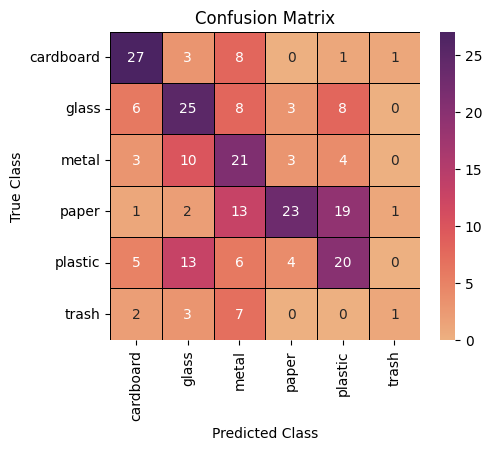

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 4))

sns.heatmap(cm, annot=True, fmt="d",
            cmap=sns.color_palette("flare", as_cmap=True),
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()


## **Multi-Class ROC Curve Calculation and Visualization**

This section of the notebook demonstrates how to evaluate a multi-class classifier by plotting ROC curves for each class. The ROC curve is a graphical representation of a classifier's performance, plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold levels.

#### Binarization of Labels
Since ROC analysis is typically used for binary classification, the multi-class labels from the validation generator are binarized using the `label_binarize` function from scikit-learn. This creates a binary matrix representation of the input, suitable for multi-class/multi-label tasks.

#### Model Predictions
The `model_tl` and `model` are used to predict class probabilities on the validation data. The `predict` method outputs the probability of each class for each sample, which is necessary to compute ROC curves.

#### ROC Computation
For each class, we use the `roc_curve` function from scikit-learn to compute the FPR and TPR, which are stored in dictionaries indexed by class. The `auc` function is then used to calculate the area under the ROC curve (AUC) for each class, providing a single score that summarizes the ROC curve's shape.

#### Plotting the ROC Curves
Each class's ROC curve is plotted in a different color, making it easy to distinguish between them. The curves are plotted on a graph with the FPR on the x-axis and the TPR on the y-axis. A dashed diagonal line represents a no-skill classifier that randomly guesses the class; a good classifier's ROC curve will appear above this line.

#### Visualization Details
- The plot is sized at 8 by 6 inches to ensure that it's large enough to be readable.
- A color cycle is used to provide distinct colors for each class's ROC curve.
- The legend indicates the AUC for each class, providing a numeric representation of the classifier's performance in distinguishing each class from the rest.
- The axes are labeled appropriately, and the plot is titled "Receiver Operating Characteristic for Multi-Class."

#### Interpretation of Results
The AUC values range from 0 to 1, where 1 indicates perfect classification and 0.5 indicates no discriminative power. In the context of multi-class classification, the micro-average, macro-average, or weighted-average AUCs can also be computed to summarize overall performance.

By plotting ROC curves and calculating AUC scores for each class, we can visually and numerically assess the model's performance across all classes.


16/16 [==============================] - 1s 61ms/step


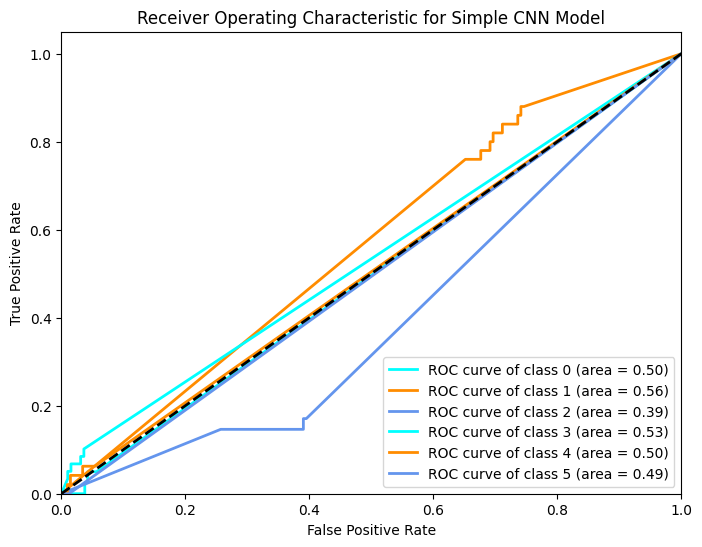

In [ ]:
# Binarize the labels for multi-class scenario
n_classes = len(validation_generator.class_indices)
true_labels = label_binarize(validation_generator.classes, classes=range(n_classes))
prediction_probabilities = model.predict(validation_generator)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], prediction_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Simple CNN Model')
plt.legend(loc="lower right")
plt.show()

# **Preprocessing**


### Integration of Preprocessing Function in Data Augmentation

When training a convolutional neural network (CNN) with a base model pre-trained on ImageNet (e.g., ResNet), it's crucial to preprocess the input images in the same manner as was done for the original model training. This code snippet demonstrates how to incorporate the `preprocess_input` function from the ResNet family's preprocessing utilities into the `ImageDataGenerator` for both training and testing datasets. This ensures that images are correctly preprocessed for model compatibility, improving training efficiency and model accuracy.

### Training Data Generator

The `train_datagen` is configured with several data augmentation parameters:
- `shear_range`, `zoom_range`, `width_shift_range`, `height_shift_range`: These parameters introduce randomness in transformations to create variation in the training data, which helps the model generalize better to unseen data.
- `horizontal_flip` and `vertical_flip`: These settings randomly flip images horizontally and vertically, further augmenting the training data.
- `validation_split`: This parameter reserves a portion of the images for validation, ensuring that the model's performance is evaluated on unseen data.
- `preprocessing_function=preprocess_input`: This crucial addition applies the specific preprocessing needed for the ResNet model, adjusting the pixel values of images accordingly.

### Testing Data Generator

Similarly, `test_datagen` uses the `preprocess_input` function for preprocessing but is configured without the augmentation options, ensuring that the validation or test data undergoes the same preprocessing steps without any augmentation. This mirrors the real-world scenario where the model needs to predict on new, unaltered images.

### Purpose and Benefit

By integrating the `preprocess_input` function directly into the `ImageDataGenerator`, all images are automatically preprocessed in the correct way as they are loaded and augmented. This streamlined approach eliminates the need for manual preprocessing steps and ensures that the model receives data in the expected format, enhancing model training and eventual predictions.



In [ ]:
# Updating the ImageDataGenerator to include the preprocessing function
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Apply ResNet preprocessing
    validation_split=0.1
)

In [ ]:
# train_generator and validation_generator as previously defined, but now they'll preprocess inputs for ResNet50
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0,
    shuffle=False
)


Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


### **Add test set**

In [ ]:
test_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

Found 251 images belonging to 6 classes.




# **Implementing Transfer Learning with ResNet50**

Transfer learning leverages a pre-trained model (in this case, ResNet50 trained on the ImageNet dataset) to benefit a related task with less data, time, or computational resources than training a model from scratch. Here's how it's done:

#### Loading the Base Model
- **ResNet50**: We load ResNet50 with `weights='imagenet'` to utilize the knowledge it has gained from ImageNet. `include_top=False` excludes the top (or last fully connected) layers of the model, making it adaptable for our custom classification task. The `input_shape` is set to `(300, 300, 3)`, tailored to our dataset's image dimensions.

#### Freezing the Base Model Layers
- **Layer Freezing**: To retain the learned features, all layers of the base model are set to `trainable = False`. This prevents the weights from being updated during training, allowing us to utilize the extracted features as they are.

#### Adding Custom Layers
- **GlobalAveragePooling2D**: Reduces the spatial dimensions of the output from the base model to a vector. This step condenses the feature maps to a single value per map, reducing the total number of parameters and computation in the network.
- **Dense Layers**: A fully connected layer with 1024 neurons follows, introducing the capacity to learn high-level features specific to our dataset. The final dense layer outputs the predictions across `num_classes` categories using a softmax activation, turning logits into probabilities.

#### Model Compilation
- The model is compiled with the Adam optimizer and `categorical_crossentropy` loss function, suitable for multi-class classification. The primary metric for evaluation is accuracy.

#### Training the Model
- **Model Fitting**: The model is trained using `train_generator` for the input data, with a defined number of `steps_per_epoch` calculated by dividing the total number of samples by the batch size. The process is repeated for a specified number of epochs (10 in this case), with performance evaluated against a separate validation set provided by `validation_generator`.

#### Observations
- This method allows for significant model performance improvements on the target task by leveraging the generic features learned by ResNet50 on ImageNet and adapting them through additional training on a specific dataset.



In [ ]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=predictions)

model_tl.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_tl = model_tl.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
142/142 [==============================] - 59s 375ms/step - loss: 0.7560 - accuracy: 0.7531 - val_loss: 0.3422 - val_accuracy: 0.8542
Epoch 2/10
142/142 [==============================] - 52s 369ms/step - loss: 0.3488 - accuracy: 0.8655 - val_loss: 0.4030 - val_accuracy: 0.8542
Epoch 3/10
142/142 [==============================] - 52s 363ms/step - loss: 0.2726 - accuracy: 0.8973 - val_loss: 0.2698 - val_accuracy: 0.8958
Epoch 4/10
142/142 [==============================] - 52s 364ms/step - loss: 0.1814 - accuracy: 0.9323 - val_loss: 0.2793 - val_accuracy: 0.8958
Epoch 5/10
142/142 [==============================] - 52s 364ms/step - loss: 0.1803 - accuracy: 0.9389 - val_loss: 0.2706 - val_accuracy: 0.8958
Epoch 6/10
142/142 [==============================] - 51s 361ms/step - loss: 0.1144 - accuracy: 0.9580 - val_loss: 0.3218 - val_accuracy: 0.8875
Epoch 7/10
142/142 [==============================] - 52s 363ms/step - loss: 0.1504 - accuracy: 0.9394 - val_loss: 0.4169 - val_ac

In [ ]:
model_tl.save("ResNet50.h5")
model_tl.save("ResNet50.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Loss Curve For Resnet50 Model**


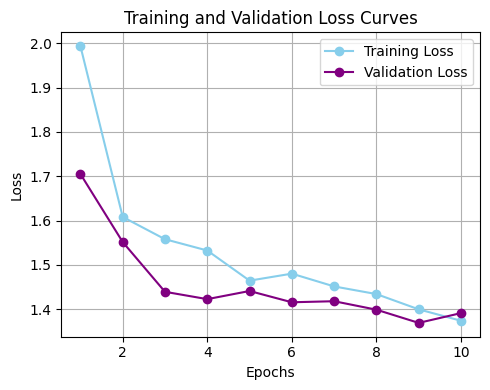

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(epochs, training_loss, label='Training Loss', color='skyblue', marker='o', linestyle='-', linewidth=1.5)
plt.plot(epochs, validation_loss, label='Validation Loss', color='purple', marker='o', linestyle='-', linewidth=1.5)

plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('/content/ResNet50_losscurves.png', transparent=True)
plt.show()


The Plot shows the training and validation loss curves over epochs during a machine learning model training process.

Here are some observations:

1. **Initial Learning**: At the very beginning (epoch 1), the training loss is much higher than the validation loss. This is unusual because typically the model performs better on the training data than on the unseen validation data. However, this can occur if there is a large initial improvement on the training set within the first epoch after the losses are calculated, or if there is a mismatch in how the training and validation losses are calculated or reported.

2. **Convergence Trend**: Both training and validation loss decrease over the first few epochs, which indicates that the model is learning and improving its predictions on both the training and validation datasets.

3. **Validation Loss Fluctuation**: From around epoch 5 onwards, the validation loss starts to fluctuate, increasing at epochs 6 and 8 before decreasing again at epoch 7 and 9.

4. **Generalization Performance**: Despite the fluctuations, the validation loss generally trends downwards or remains stable, which suggests that the model has not started to overfit to the training data significantly. Overfitting is typically indicated by a continuous increase in validation loss while the training loss decreases, which is not the case here.

5. **Training Loss Stability**: The training loss appears to have plateaued from around epoch 7 onwards, suggesting that the model may not be learning significantly from the training data past this point. This could be due to the model reaching its capacity, or it might require adjustments in the learning rate or a more complex model to continue decreasing the training loss.

6. **Final Assessment**: By the final epoch (epoch 10), the training loss is lower than the validation loss, which is expected as the model is trained to minimize the training loss.

In terms of action points, here are some recommendations:
- Investigate why the training loss starts out higher than the validation loss.
- Ensure that the validation set is representative of the problem space and is consistent with the training data distribution.
- Evaluate other metrics such as accuracy, precision, recall, or F1-score which we already did to get a better understanding of model performance, as loss values alone may not fully represent the performance, especially when the loss is low.


## **F1 Score**

In [ ]:
predictions = model_tl.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

# Converting predictions from one-hot encoded to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate the F1 score
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print('F1 Score:', f1)

16/16 [==============================] - 7s 285ms/step
F1 Score: 0.9183561335220111


In [ ]:
# Generate and print a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Note: This returns the loss and accuracy defined during model compilation
loss, accuracy = model_tl.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

              precision    recall  f1-score   support

   cardboard       1.00      0.82      0.90        40
       glass       0.94      0.94      0.94        50
       metal       0.93      0.98      0.95        41
       paper       0.86      1.00      0.92        59
     plastic       0.92      0.92      0.92        48
       trash       1.00      0.62      0.76        13

    accuracy                           0.92       251
   macro avg       0.94      0.88      0.90       251
weighted avg       0.93      0.92      0.92       251

16/16 [==============================] - 2s 104ms/step - loss: 0.2035 - accuracy: 0.9203
Loss: 0.2035
Accuracy: 0.9203


## **Confusion Matrix**

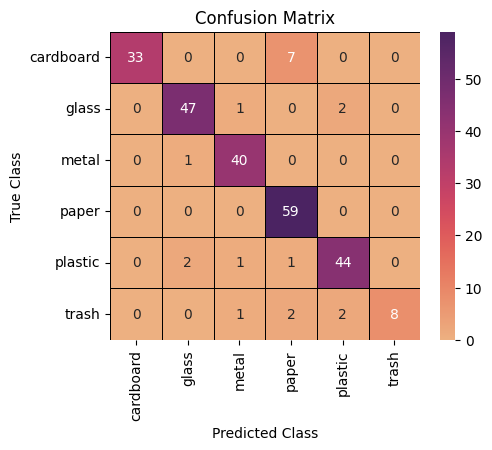

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 4))

sns.heatmap(cm, annot=True, fmt="d",
            cmap=sns.color_palette("flare", as_cmap=True),
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()


## **Multi-Class ROC Curve Calculation and Visualization**


16/16 [==============================] - 2s 101ms/step


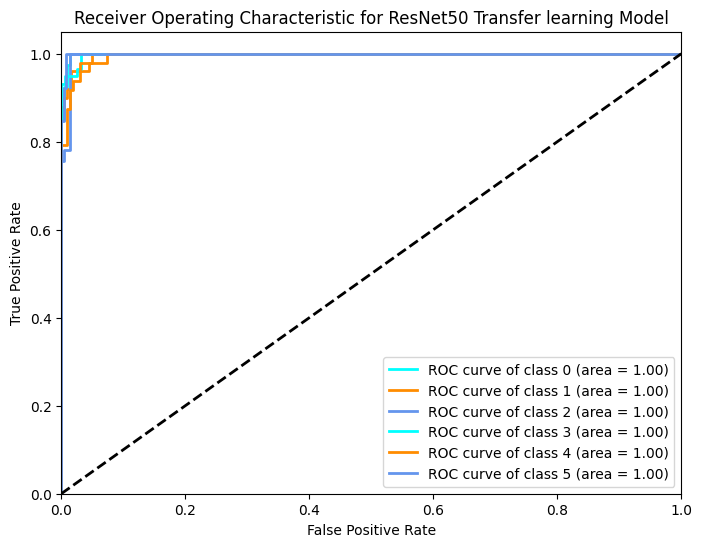

In [ ]:
# Binarize the labels for multi-class scenario
n_classes = len(validation_generator.class_indices)
true_labels = label_binarize(validation_generator.classes, classes=range(n_classes))
prediction_probabilities = model_tl.predict(validation_generator)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], prediction_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for ResNet50 Transfer learning Model')
plt.legend(loc="lower right")
plt.show()


# **Regularization and Dropout in models**

In [ ]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Add custom layers on top of the base model with L2 regularization and Dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_tl_dropout = Model(inputs=base_model.input, outputs=predictions)

model_tl_dropout.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_tl_dropout = model_tl_dropout.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/10
142/142 [==============================] - 104s 485ms/step - loss: 6.5082 - accuracy: 0.4491 - val_loss: 2.7151 - val_accuracy: 0.4542
Epoch 2/10
142/142 [==============================] - 66s 467ms/step - loss: 1.7957 - accuracy: 0.5788 - val_loss: 2.1968 - val_accuracy: 0.5000
Epoch 3/10
142/142 [==============================] - 65s 456ms/step - loss: 1.1932 - accuracy: 0.6389 - val_loss: 16.8971 - val_accuracy: 0.2542
Epoch 4/10
142/142 [==============================] - 66s 465ms/step - loss: 1.0483 - accuracy: 0.6735 - val_loss: 2.2092 - val_accuracy: 0.4208
Epoch 5/10
142/142 [==============================] - 66s 462ms/step - loss: 0.9689 - accuracy: 0.7009 - val_loss: 1.4287 - val_accuracy: 0.5458
Epoch 6/10
142/142 [==============================] - 71s 497ms/step - loss: 0.9620 - accuracy: 0.6885 - val_loss: 1.2787 - val_accuracy: 0.5958
Epoch 7/10
142/142 [==============================] - 81s 564ms/step - loss: 0.9078 - accuracy: 0.7044 - val_loss: 1.4074 - val_



# **Implementing Transfer Learning with VGG-16**

Transfer learning leverages a pre-trained model (in this case, VGG-16 trained on the ImageNet dataset) to benefit a related task with less data, time, or computational resources than training a model from scratch. Similarly to ResNet50, here's how it's done:

#### Loading the Base Model
- **VGG-16**: We load VGG-16 with `weights='imagenet'` to utilize the knowledge it has gained from ImageNet. `include_top=False` excludes the top (or last fully connected) layers of the model, making it adaptable for our custom classification task. The `input_shape` is set to `(300, 300, 3)`, tailored to our dataset's image dimensions.

#### Freezing the Base Model Layers
- **Layer Freezing**: To retain the learned features, all layers of the base model are set to `trainable = False`. This prevents the weights from being updated during training, allowing us to utilize the extracted features as they are.

#### Adding Custom Layers
- **GlobalAveragePooling2D**: Reduces the spatial dimensions of the output from the base model to a vector. This step condenses the feature maps to a single value per map, reducing the total number of parameters and computation in the network.
- **Dense Layers**: A fully connected layer with 1024 neurons follows, introducing the capacity to learn high-level features specific to our dataset. The final dense layer outputs the predictions across `num_classes` categories using a softmax activation, turning logits into probabilities.

#### Model Compilation
- The model is compiled with the Adam optimizer and `categorical_crossentropy` loss function, suitable for multi-class classification. The primary metric for evaluation is accuracy.

#### Training the Model
- **Model Fitting**: The model is trained using `train_generator` for the input data, with a defined number of `steps_per_epoch` calculated by dividing the total number of samples by the batch size. The process is repeated for a specified number of epochs (10 in this case), with performance evaluated against a separate validation set provided by `validation_generator`.

#### Observations
- This method allows for significant model performance improvements on the target task by leveraging the generic features learned by ResNet50 on ImageNet and adapting them through additional training on a specific dataset.



![vgg](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*MTuQrB_uw_xr2jzBqg2GUw.png)

In [ ]:
# Load VGG-16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_tl_vgg16 = Model(inputs=base_model.input, outputs=predictions)

model_tl_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_tl_vgg16 = model_tl_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
142/142 [==============================] - 63s 396ms/step - loss: 0.9648 - accuracy: 0.7235 - val_loss: 0.6397 - val_accuracy: 0.7625
Epoch 2/10
142/142 [==============================] - 53s 374ms/step - loss: 0.4118 - accuracy: 0.8527 - val_loss: 0.5090 - val_accuracy: 0.8292
Epoch 3/10
142/142 [==============================] - 53s 372ms/step - loss: 0.3142 - accuracy: 0.8881 - val_loss: 0.4398 - val_accuracy: 0.8458
Epoch 4/10
142/142 [==============================] - 52s 368ms/step - loss: 0.2230 - accuracy: 0.9208 - val_loss: 0.4818 - val_accuracy: 0.8542
Epoch 5/10
142/142 [==============================] - 57s 403ms/step - loss: 0.1598 - accuracy: 0.9465 - val_loss: 0.4000 - val_accuracy: 0.8833
Epoch 6/10
142/142 [==============================] - 54s 376ms/step - loss: 0.1540 - accuracy: 0.9469 - val_loss: 0.4605 - val_accuracy: 0.8583
Epoch 7/10
142/142 [==============================] - 53s 374ms/step - loss: 0.1199 - accuracy: 0.9588 - val_loss: 0.4247 - val_ac

In [ ]:
model_tl_vgg16.save("VGG16.h5")
model_tl_vgg16.save("VGG16.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Loss Curve For VGG-16 Model**


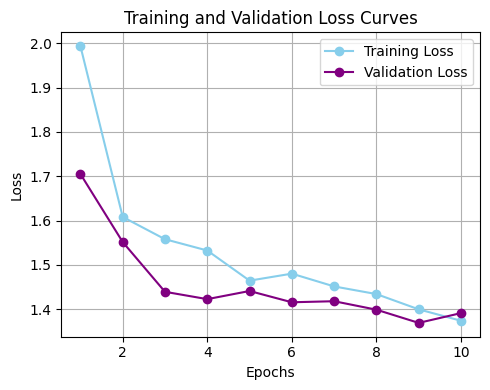

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(epochs, training_loss, label='Training Loss', color='skyblue', marker='o', linestyle='-', linewidth=1.5)
plt.plot(epochs, validation_loss, label='Validation Loss', color='purple', marker='o', linestyle='-', linewidth=1.5)

plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('/content/vgg16_losscurves.png', transparent=True)
plt.show()

## **F1 Score**

In [ ]:
predictions = model_tl_vgg16.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

# Converting predictions from one-hot encoded to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate the F1 score
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print('F1 Score:', f1)

16/16 [==============================] - 7s 435ms/step
F1 Score: 0.8536324493640158


In [ ]:
# Generate and print a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Note: This returns the loss and accuracy defined during model compilation
loss, accuracy = model_tl_vgg16.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

              precision    recall  f1-score   support

   cardboard       0.97      0.82      0.89        40
       glass       0.91      0.80      0.85        50
       metal       0.72      0.95      0.82        41
       paper       0.88      0.85      0.86        59
     plastic       0.81      0.90      0.85        48
       trash       1.00      0.69      0.82        13

    accuracy                           0.85       251
   macro avg       0.88      0.84      0.85       251
weighted avg       0.87      0.85      0.85       251

16/16 [==============================] - 2s 125ms/step - loss: 0.4829 - accuracy: 0.8526
Loss: 0.4829
Accuracy: 0.8526


## **Confusion Matrix**

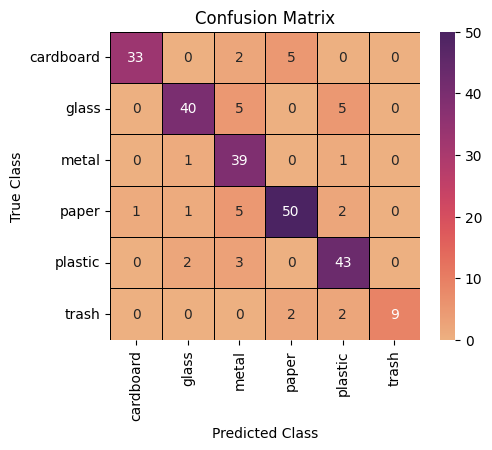

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 4))

sns.heatmap(cm, annot=True, fmt="d",
            cmap=sns.color_palette("flare", as_cmap=True),
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()


## **Multi-Class ROC Curve Calculation and Visualization**


16/16 [==============================] - 2s 127ms/step


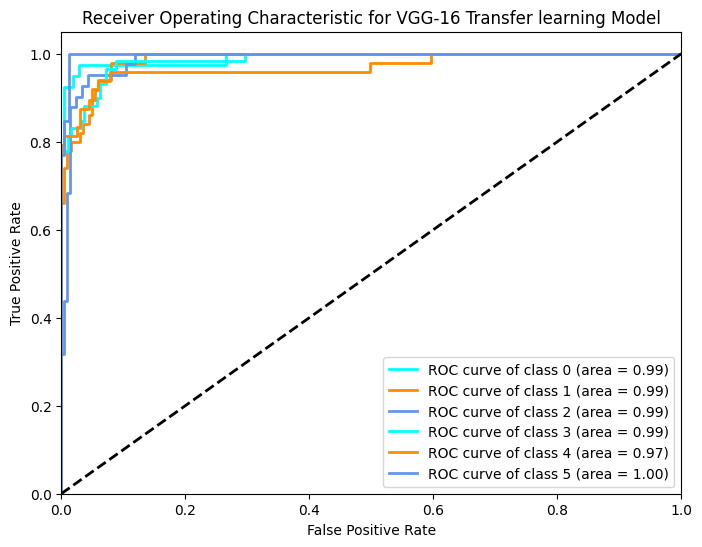

In [ ]:
# Binarize the labels for multi-class scenario
n_classes = len(validation_generator.class_indices)
true_labels = label_binarize(validation_generator.classes, classes=range(n_classes))
prediction_probabilities = model_tl_vgg16.predict(validation_generator)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], prediction_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for VGG-16 Transfer learning Model')
plt.legend(loc="lower right")
plt.show()


# **Implementing Transfer Learning with DenseNet121**

### **With stratified k-fold**
Add L2 regularization, more aggressive data aug, and early stopping

In [ ]:
# Prepare the dataset
data = []
labels = []
class_names = os.listdir(base_path)
label_to_index = {class_name: idx for idx, class_name in enumerate(sorted(class_names))}

for class_name in class_names:
    class_dir = os.path.join(base_path, class_name)
    if os.path.isdir(class_dir):
        for img in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img)
            data.append(img_path)
            labels.append(label_to_index[class_name])

# Convert labels to integer indices
labels = np.array(labels)

# Define the k-fold cross-validator
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# K-fold Cross Validation model evaluation
fold_no = 1

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  # Increased from 0.1 to 0.2
    zoom_range=0.2,  # Increased from 0.1 to 0.2
    width_shift_range=0.2,  # Increased from 0.1 to 0.2
    height_shift_range=0.2,  # Increased from 0.1 to 0.2
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,  # New: Rotate images by up to 20 degrees
    fill_mode='nearest'  # New: Fill in new pixels after rotation or width/height shift
)

for train_index, val_index in kf.split(data, labels):
    train_data = np.array(data)[train_index]
    val_data = np.array(data)[val_index]
    train_labels = labels[train_index]
    val_labels = labels[val_index]

    # Convert indices back to class names for DataFrame compatibility with flow_from_dataframe
    train_labels_str = [class_names[label] for label in train_labels]
    val_labels_str = [class_names[label] for label in val_labels]

    # Create DataFrames for the generators
    train_df = pd.DataFrame({'filename': train_data, 'class': train_labels_str})
    val_df = pd.DataFrame({'filename': val_data, 'class': val_labels_str})

    # Define the model architecture
    # Your model definition code here
    # Load DenseNet121 base model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

    # Set the base model's layers to non-trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Continue with your custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # Added L2 regularization
    x = Dropout(0.5)(x)  # Increased dropout
    predictions = Dense(len(class_names), activation='softmax')(x)

    print(f'Training for fold {fold_no} ...')

    # Create the final model
    model_tl_dense = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model_tl_dense.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


    # Train the model
    history_tl_dense = model_tl_dense.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping]
    )

    # Increase fold number
    fold_no += 1

Training for fold 1 ...
Epoch 1/10
142/142 [==============================] - 68s 394ms/step - loss: 2.8631 - accuracy: 0.4916 - val_loss: 1.6742 - val_accuracy: 0.5833
Epoch 2/10
142/142 [==============================] - 51s 360ms/step - loss: 1.5496 - accuracy: 0.5996 - val_loss: 1.4559 - val_accuracy: 0.6000
Epoch 3/10
142/142 [==============================] - 50s 353ms/step - loss: 1.3867 - accuracy: 0.6451 - val_loss: 1.1928 - val_accuracy: 0.6958
Epoch 4/10
142/142 [==============================] - 51s 356ms/step - loss: 1.2834 - accuracy: 0.6588 - val_loss: 1.2161 - val_accuracy: 0.6208
Epoch 5/10
142/142 [==============================] - 51s 361ms/step - loss: 1.1987 - accuracy: 0.6748 - val_loss: 1.1492 - val_accuracy: 0.6750
Epoch 6/10
142/142 [==============================] - 51s 360ms/step - loss: 1.1599 - accuracy: 0.6863 - val_loss: 1.1664 - val_accuracy: 0.6708
Epoch 7/10
142/142 [==============================] - 51s 356ms/step - loss: 1.1180 - accuracy: 0.7000 - v

In [ ]:
model_tl_dense.save("DenseNet121.h5")
model_tl_dense.save("DenseNet121.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Without stratified k-fold**

In [ ]:
# # Load DenseNet121 base model
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# # Set the base model's layers to non-trainable
# for layer in base_model.layers:
#     layer.trainable = False

# # Continue with your custom top layers
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(num_classes, activation='softmax')(x)

# # Create the final model
# model_tl_dense = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model
# model_tl_dense.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Train the model
# history_tl_dense = model_tl_dense.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size
# )

# # Define the path for the results file
# # results_path = '/content/Saved Models_CDS_Project/DenseNet121_trainingresults.txt'

# # # Extract training and validation loss and accuracy from the history object
# # training_loss = history_tl_dense.history['loss']
# # validation_loss = history_tl_dense.history['val_loss']
# # training_accuracy = history_tl_dense.history['accuracy']
# # validation_accuracy = history_tl_dense.history['val_accuracy']
# # epochs = range(1, len(training_loss) + 1)

# # # Open the file and write the epoch-by-epoch results
# # with open(results_path, 'w') as file:
# #     file.write("Epoch,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy\n")
# #     for epoch in epochs:
# #         file.write(f"{epoch},{training_loss[epoch-1]:.4f},{validation_loss[epoch-1]:.4f},"
# #                    f"{training_accuracy[epoch-1]:.4f},{validation_accuracy[epoch-1]:.4f}\n")

# # files.download(results_path)

# # model_tl_dense.save('/content/Saved Models_CDS_Project/DenseNet121')

## **Loss curve for densenet121**


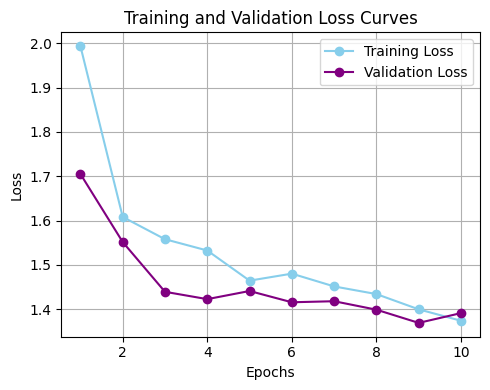

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(epochs, training_loss, label='Training Loss', color='skyblue', marker='o', linestyle='-', linewidth=1.5)
plt.plot(epochs, validation_loss, label='Validation Loss', color='purple', marker='o', linestyle='-', linewidth=1.5)

plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('/content/densenet121_losscurves.png', transparent=True)
plt.show()

## **F1 Score**

In [ ]:
predictions = model_tl_dense.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

# Converting predictions from one-hot encoded to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate the F1 score
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print('F1 Score:', f1)

16/16 [==============================] - 8s 383ms/step
F1 Score: 0.706753014109922


In [ ]:
# Generate and print a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Note: This returns the loss and accuracy defined during model compilation
loss, accuracy = model_tl_dense.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

              precision    recall  f1-score   support

   cardboard       0.82      0.70      0.76        40
       glass       0.72      0.58      0.64        50
       metal       0.58      0.80      0.67        41
       paper       0.86      0.81      0.83        59
     plastic       0.67      0.58      0.62        48
       trash       0.50      0.85      0.63        13

    accuracy                           0.71       251
   macro avg       0.69      0.72      0.69       251
weighted avg       0.73      0.71      0.71       251

16/16 [==============================] - 2s 101ms/step - loss: 1.0421 - accuracy: 0.7052
Loss: 1.0421
Accuracy: 0.7052


## **Confusion Matrix**

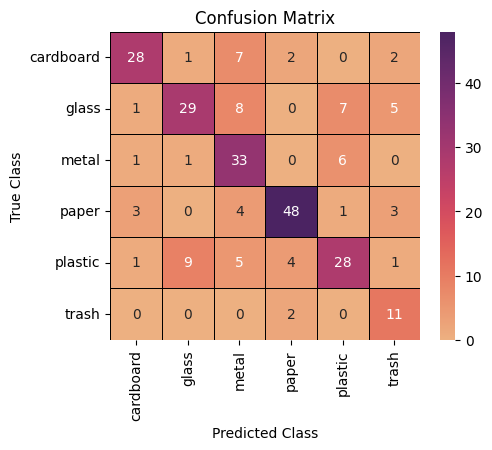

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 4))

sns.heatmap(cm, annot=True, fmt="d",
            cmap=sns.color_palette("flare", as_cmap=True),
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()


## **Multi-Class ROC Curve Calculation and Visualization**


16/16 [==============================] - 1s 81ms/step


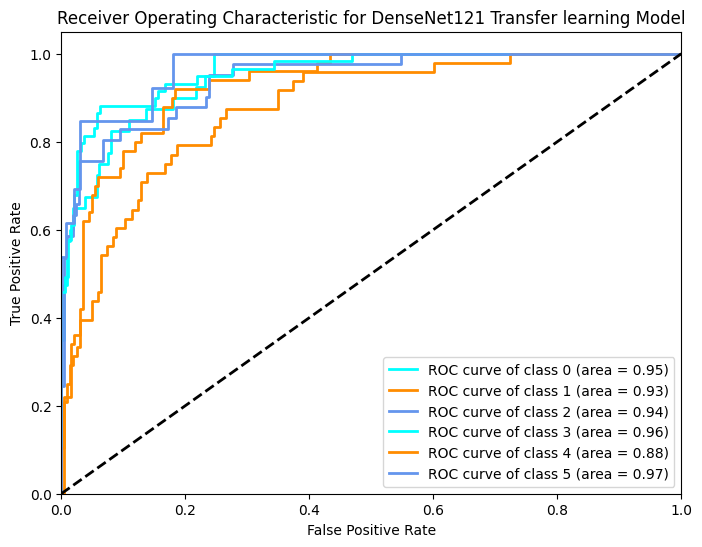

In [ ]:
# Binarize the labels for multi-class scenario
n_classes = len(validation_generator.class_indices)
true_labels = label_binarize(validation_generator.classes, classes=range(n_classes))
prediction_probabilities = model_tl_dense.predict(validation_generator)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], prediction_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for DenseNet121 Transfer learning Model')
plt.legend(loc="lower right")
plt.show()


# **Comparison of accuracy of 3 models**

- **Subplots**: The `plt.subplot(1, 2, 1)`, `plt.subplot(1, 2, 2)` and `plt.subplot(1, 2, 3)` functions are used to create side-by-side subplots (one row, three columns) for comparing the accuracies of Model 1, 2, and 3 respectively.

- **Accuracy Data**: The training and validation accuracies are extracted from the `history` and `history_tl` objects for both models. These values are plotted against the number of epochs, allowing us to observe how accuracy changes throughout the training process.

- **Plot Customization**: Each subplot includes both training and validation accuracies plotted with different colors and markers for clear differentiation. Titles, axis labels, and legends are added for clarity, and a grid is used to improve readability.

- **Visualization Goals**: By comparing these plots, you can determine:
  - Which model achieves higher accuracy on the training and validation datasets.
  - How quickly each model learns (rate of improvement in accuracy across epochs).
  - Whether overfitting is a concern for either model, indicated by a significant gap between training and validation accuracies.

This comparative visualization is invaluable for model selection, tuning, and understanding the learning dynamics of different architectures or training configurations.

<ipython-input-45-05d64e4d4f55>:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, training_accuracy_model_1, 'bo-', label='Training Accuracy', color='skyblue', marker='o', linestyle='-', linewidth=1.5)
<ipython-input-45-05d64e4d4f55>:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, training_accuracy_model_1, 'bo-', label='Training Accuracy', color='skyblue', marker='o', linestyle='-', linewidth=1.5)
<ipython-input-45-05d64e4d4f55>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, training_accuracy_model_1, 'bo-', label='Training Accuracy', color='skyblue', marker='o', linestyle='-', l

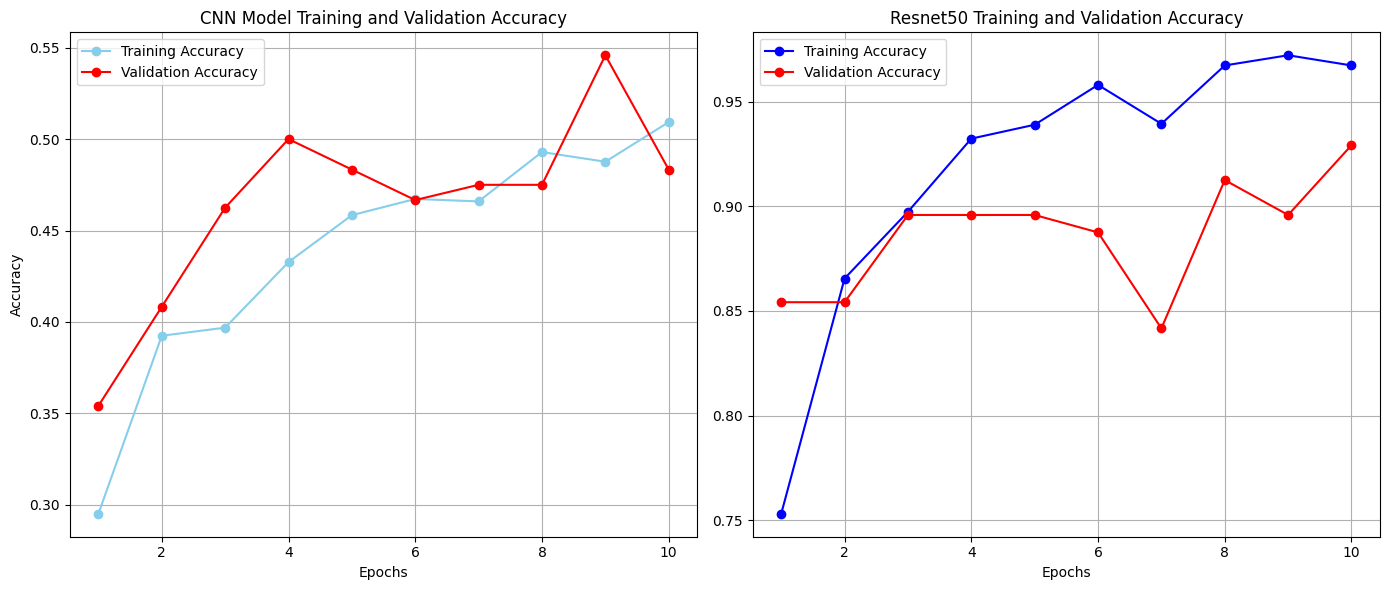

In [ ]:
training_accuracy_model_1 = history.history['accuracy']
validation_accuracy_model_1 = history.history['val_accuracy']

training_accuracy_model_2 = history_tl.history['accuracy']
validation_accuracy_model_2 = history_tl.history['val_accuracy']

training_accuracy_model_3 = history_tl_vgg16.history['accuracy']
validation_accuracy_model_3 = history_tl_vgg16.history['val_accuracy']

training_accuracy_model_4 = history_tl_dense.history['accuracy']
validation_accuracy_model_4 = history_tl_dense.history['val_accuracy']

epochs = range(1, len(training_accuracy_model_1) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy_model_1, 'bo-', label='Training Accuracy', color='skyblue', marker='o', linestyle='-', linewidth=1.5)
plt.plot(epochs, validation_accuracy_model_1, 'ro-', label='Validation Accuracy', marker='o', linestyle='-', linewidth=1.5)
plt.title('CNN Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy_model_2, 'bo-', label='Training Accuracy', marker='o', linestyle='-', linewidth=1.5)
plt.plot(epochs, validation_accuracy_model_2, 'ro-', label='Validation Accuracy', marker='o', linestyle='-', linewidth=1.5)
plt.title('Resnet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


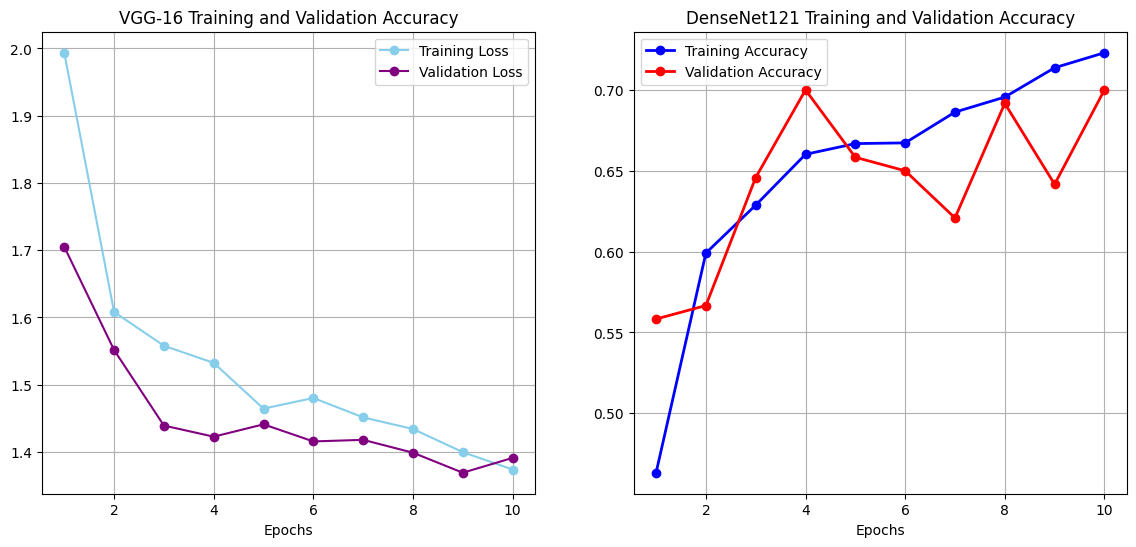

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', color='skyblue', marker='o', linestyle='-', linewidth=1.5)
plt.plot(epochs, validation_loss, label='Validation Loss', color='purple', marker='o', linestyle='-', linewidth=1.5)
plt.title('VGG-16 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy_model_4, 'bo-', label='Training Accuracy', linewidth=2)
plt.plot(epochs, validation_accuracy_model_4, 'ro-', label='Validation Accuracy', linewidth=2)
plt.title('DenseNet121 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

This plot compares the training and validation accuracy of two different convolutional neural network (CNN) models across training epochs: a custom CNN model and a ResNet50 model.

**Custom CNN Model Analysis:**

1. **Improvement Over Time**: The training and validation accuracy both increase over epochs, indicating that the model is learning from the data.

2. **Convergence**: There is a point, around epoch 6, where both training and validation accuracy stabilize, suggesting that the model has largely learned the features from the dataset and is not improving significantly after this point.

3. **Small Gap**: The gap between training and validation accuracy is relatively small, which indicates good generalization. However, the overall accuracy values are not very high (peaking around 50%), which might suggest that the problem is challenging, the model is not complex enough, or the model may need more data or further tuning to improve its performance.

**ResNet50 Model Analysis:**

1. **High Accuracy**: The training accuracy is very high, close to 97.5%, which is expected as ResNet50 is a powerful model pre-trained on a large dataset (ImageNet).

2. **Validation Accuracy**: The validation accuracy increases and closely follows the training accuracy until around epoch 6, after which it starts to decline sharply while the training accuracy remains stable. This divergence can be a sign of overfitting, where the model performs well on the training data but increasingly poorly on unseen data.

3. **Early Stopping Point**: Given the sharp decline in validation accuracy after epoch 6, it could be beneficial to stop training at this point to prevent further overfitting. Techniques such as early stopping would be useful here.


**General Observations and Recommendations:**

- **Data Representation**: Ensure that the validation set is representative of the problem space and is consistent with the training data distribution.
- **Model Complexity**: The custom CNN model may benefit from increased complexity or further hyperparameter tuning to improve its accuracy.
- **Early Stopping**: Implement early stopping based on validation accuracy to prevent overfitting for the ResNet50 model.



# **Evaluation**

The function `display_predictions_actuals_before_processing` is a useful tool for visually assessing the performance of your trained model on random images from your dataset. It showcases how the model's predictions compare to the actual labels for a selection of images, prior to any preprocessing steps applied by data generators during training or validation phases.

### Function Overview

- **Objective**: The main goal of this function is to randomly select a few images from the dataset, display them, and compare the model's predictions against their actual labels. This visual feedback is invaluable for understanding the model's performance and identifying potential areas for improvement.

- **Parameters**:
  - `model`: The trained model used for making predictions.
  - `base_path`: The root directory of the dataset, where images are organized into subdirectories named after their respective classes.
  - `class_indices`: A dictionary mapping from class names to class indices, as used by the model.
  - `num_images`: The number of images to randomly select and display.

### Function Details

1. **Index-Class Mapping**: The function first reverses the `class_indices` dictionary to map numeric indices back to class names. This is necessary for interpreting the model's predictions, which are output as numeric class indices.

2. **Image Selection**: It then compiles a list of all images in the dataset, traversing each class directory and collecting image paths. From this list, it randomly selects `num_images` images to use for prediction and display.

3. **Image Loading and Preprocessing**: For each selected image, the function loads the image, resizes it to the target size expected by the model (300x300 pixels in this example), and applies the necessary preprocessing. The preprocessing step is crucial as it aligns the images with the format and scale the model was trained on, ensuring accurate predictions.

4. **Model Prediction**: With the images prepared, the function uses the model to predict the class of each image. It then maps the predicted class indices back to class names using the index-class mapping prepared earlier.

5. **Visualization**: Finally, each selected image is displayed alongside its predicted and actual class names. This side-by-side comparison provides a clear visual reference to evaluate the model's predictive accuracy on individual images.

### Utility in Machine Learning Workflow

This function serves several important purposes in a machine learning project:

- **Model Evaluation**: Beyond quantitative metrics like accuracy or loss, visual inspection of predictions provides qualitative insights into the model's behavior, such as its strengths and weaknesses in recognizing certain features or classes.

- **Error Analysis**: By examining cases where the model's predictions diverge from actual labels, researchers and developers can identify specific areas where the model may require additional training data, fine-tuning, or architectural adjustments.

- **Demonstration and Interpretability**: Such visualizations are also effective for demonstrating model capabilities to stakeholders or for educational purposes, offering an intuitive understanding of what the model has learned.



1/1 [==============================] - 1s 945ms/step


1/1 [==============================] - 0s 28ms/step


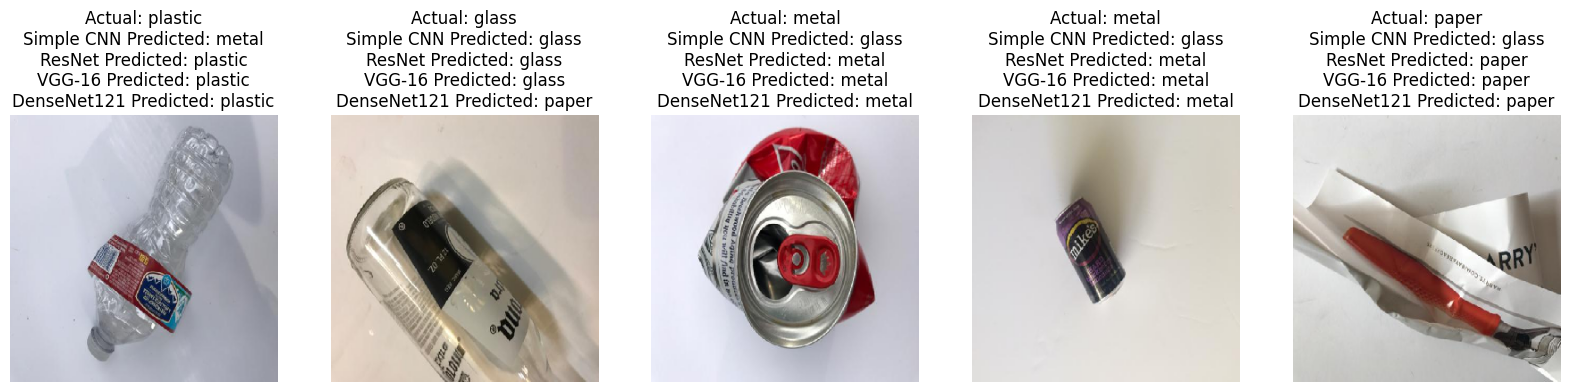

In [ ]:
def display_predictions_actuals_before_processing(model, base_path, class_indices, num_images=5):
    """
    Display predictions vs actual labels for random images before preprocessing.

    Parameters:
    - model: The trained model for predictions.
    - base_path: The path to the dataset directory.
    - class_indices: A dictionary mapping class names to class indices.
    - num_images: Number of random images to display.
    """
    # Reverse the class_indices dict to map indices to class names
    index_to_class = {v: k for k, v in class_indices.items()}

    # Get all image paths and their corresponding class names
    all_images = []
    for class_name in os.listdir(base_path):
        class_dir = os.path.join(base_path, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                all_images.append((img_path, class_name))

    # Randomly select images
    selected_images = random.sample(all_images, num_images)

    plt.figure(figsize=(20, 4))

    for i, (img_path, actual_class) in enumerate(selected_images):
        # Load image
        img = image.load_img(img_path, target_size=(300, 300))
        img_array = image.img_to_array(img)
        img_array_expanded = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_array_expanded)

        # Predict
        prediction = model.predict(img_preprocessed)
        predicted_class = index_to_class[np.argmax(prediction)]

        prediction_1 = model_tl.predict(img_preprocessed)
        predicted_1_class = index_to_class[np.argmax(prediction_1)]

        prediction_2 = model_tl_vgg16.predict(img_preprocessed)
        predicted_2_class = index_to_class[np.argmax(prediction_2)]

        prediction_3 = model_tl_dense.predict(img_preprocessed)
        predicted_3_class = index_to_class[np.argmax(prediction_3)]

        # Display

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)  # Display original image
        plt.title(f'Actual: {actual_class}\nSimple CNN Predicted: {predicted_class}\nResNet Predicted: {predicted_1_class}\nVGG-16 Predicted: {predicted_2_class}\nDenseNet121 Predicted: {predicted_3_class}')
        plt.axis('off')

    plt.show()


class_indices = test_generator.class_indices

display_predictions_actuals_before_processing(model, base_path, class_indices, num_images=5)

# **Reload Models**

In [ ]:
# model_0 = load_model('/content/models/CNN.h5') # simple cnn
# # model_1 = load_model('/content/models/resnet50.h5') # resnet50
# model_2 = load_model('/content/models/VGG16.h5') # vgg16
# model_3 = load_model('/content/models/DenseNet121.h5') #densenet

In [ ]:
# model_0 = load_model('/content/models/cnn.h5') # simple cnn
# model_1 = load_model('/content/models/resnet50.h5') # resnet50
# model_2 = load_model('/content/models/vgg16.h5') # vgg16
# model_3 = load_model('/content/models/densenet.h5') #densenet
# test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

#  use the 'validation' subset for testing
# test_generator = test_datagen.flow_from_directory(
#     base_path,
#     target_size=(300, 300),
#     batch_size=32,
#     class_mode='categorical',
#     subset='validation',
#     shuffle=False
# )

test_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

def predict_with_model(model, generator):
    steps = np.ceil(generator.samples / generator.batch_size)
    predictions = model.predict(generator, steps=steps)
    return np.argmax(predictions, axis=1)

def majority_voting(predictions_list):
    predictions_per_image = np.array(predictions_list).T
    majority_votes = [np.bincount(image_preds).argmax() for image_preds in predictions_per_image]
    return majority_votes

# only testing with two models now my cnn and my resnet50, to replace with the actual models - resnet50 vgg16 and densenet
# predictions_model_tl = predict_with_model(model_tl, test_generator)
# predictions_model = predict_with_model(model, test_generator)
predictions_cnn = predict_with_model(model, test_generator)
predictions_resnet50 = predict_with_model(model_tl, test_generator)
predictions_vgg16 = predict_with_model(model_tl_vgg16, test_generator)
predictions_densenet121 = predict_with_model(model_tl_dense, test_generator)

# predictions_placeholder = np.random.choice([0, 1], size=(len(test_generator.filenames)))

final_predictions = majority_voting([predictions_cnn, predictions_resnet50, predictions_vgg16])

Found 2527 images belonging to 6 classes.
158/158 [==============================] - 19s 120ms/step


In [ ]:
ground_truth = test_generator.classes

correct_predictions = sum(final_predictions == ground_truth)

total_predictions = len(ground_truth)
accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy * 100:.2f}%')

#this prints out the accuracy - to do comparison between the 3 methods after this

Accuracy: 97.11%
